In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [25]:
#!/bin/bash
!curl -L -o '/content/drive/MyDrive/ML_Lab/chess.zip' https://www.kaggle.com/api/v1/datasets/download/anshulmehtakaggl/chess-pieces-detection-images-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3555k  100 3555k    0     0  10.7M      0 --:--:-- --:--:-- --:--:-- 10.7M


In [26]:
!unzip '/content/drive/MyDrive/ML_Lab/chess.zip' -d '/content/drive/MyDrive/ML_Lab/chess'

Archive:  /content/drive/MyDrive/ML_Lab/chess.zip
  inflating: /content/drive/MyDrive/ML_Lab/chess/Queen-Resized/00000000_resized.jpg  
  inflating: /content/drive/MyDrive/ML_Lab/chess/Queen-Resized/00000001_resized.jpg  
  inflating: /content/drive/MyDrive/ML_Lab/chess/Queen-Resized/00000003_resized.jpg  
  inflating: /content/drive/MyDrive/ML_Lab/chess/Queen-Resized/00000004_resized.jpg  
  inflating: /content/drive/MyDrive/ML_Lab/chess/Queen-Resized/00000005_resized.jpg  
  inflating: /content/drive/MyDrive/ML_Lab/chess/Queen-Resized/00000007_resized.jpg  
  inflating: /content/drive/MyDrive/ML_Lab/chess/Queen-Resized/00000008_resized.jpg  
  inflating: /content/drive/MyDrive/ML_Lab/chess/Queen-Resized/00000010_resized.jpg  
  inflating: /content/drive/MyDrive/ML_Lab/chess/Queen-Resized/00000011_resized.jpg  
  inflating: /content/drive/MyDrive/ML_Lab/chess/Queen-Resized/00000012_resized.jpg  
  inflating: /content/drive/MyDrive/ML_Lab/chess/Queen-Resized/00000013_resized.jpg  
  in

In [29]:
# Path to chess piece images
dataset_path = '/content/drive/MyDrive/ML_Lab/chess'
img_size = (224, 224)
batch_size = 32
seed = 42

In [30]:
# Load full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True  # Shuffle before splitting
)

Found 651 files belonging to 5 classes.


In [31]:
# Split manually: 80% train, 20% test
dataset_size = len(full_ds)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

In [32]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
])

In [33]:
# Apply augmentation
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

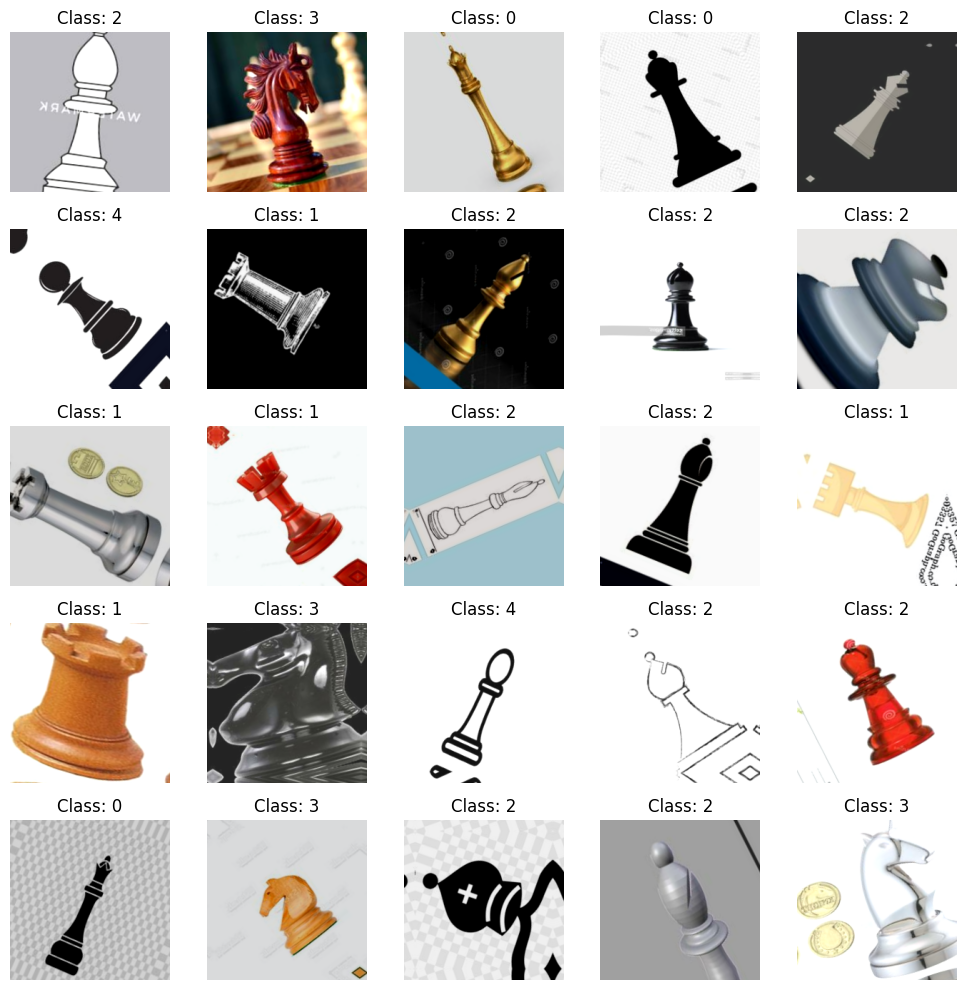

In [34]:
# Show Images

import matplotlib.pyplot as plt

# Take a single batch of images from the augmented training dataset
image_batch, label_batch = next(iter(augmented_train_ds))

# Number of images to display (25 in a 5x5 grid)
num_images_to_display = 25

# Create a 5x5 grid for the images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the images in the batch
for i in range(num_images_to_display):
  ax = axes[i // 5, i % 5]  # Get the current subplot
  ax.imshow(image_batch[i].numpy().astype("uint8"))  # Display the image
  ax.set_title(f"Class: {label_batch[i].numpy()}")  # Set the class label as the title
  ax.axis("off")  # Turn off axes

plt.tight_layout()
plt.show()


In [35]:
# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [36]:
# Build Custom CNN model
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3), name='input_layer'),
    Rescaling(1./255),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(full_ds.class_names), activation='softmax')
])

# Compile
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,524,805 (24.89 MB)

 Trainable params: 6,524,805 (24.89 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Train
history = model.fit(augmented_train_ds, epochs=10)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 356ms/step - accuracy: 0.1980 - loss: 2.2167
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - accuracy: 0.2175 - loss: 1.6059
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step - accuracy: 0.2134 - loss: 1.6026
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.2772 - loss: 1.5970
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 431ms/step - accuracy: 0.2388 - loss: 1.5954
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.2508 - loss: 1.5963
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - accuracy: 0.2618 - loss: 1.5922
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.2578 - loss: 1.5942
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 444ms/step - accuracy: 0.2531 - loss: 1.5932
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 363ms/step - accuracy: 0.2314 - loss: 1.5901


In [40]:
# Test
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.8533 - loss: 0.6523
Test Accuracy: 0.85


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 616ms/step - accuracy: 0.2700 - loss: 46.2427 - val_accuracy: 0.6331 - val_loss: 3.0618
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 489ms/step - accuracy: 0.6166 - loss: 2.7788 - val_accuracy: 0.7266 - val_loss: 1.1795
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 493ms/step - accuracy: 0.6459 - loss: 1.1936 - val_accuracy: 0.6115 - val_loss: 0.9851
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 598ms/step - accuracy: 0.6990 - loss: 0.7920 - val_accuracy: 0.7986 - val_loss: 0.5789
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 524ms/step - accuracy: 0.6779 - loss: 0.8519 - val_accuracy: 0.8489 - val_loss: 0.4445
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 494ms/step - accuracy: 0.7784 - loss: 0.7003 - val_accuracy: 0.8633 - val_loss: 0.4259
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 529ms/step - accuracy: 0.7803 - loss: 0.7024 - val_accuracy: 0.8777 - val_loss: 0.5031
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 564ms/step - accuracy: 0.8234 - loss: 0.5452 - val_accura

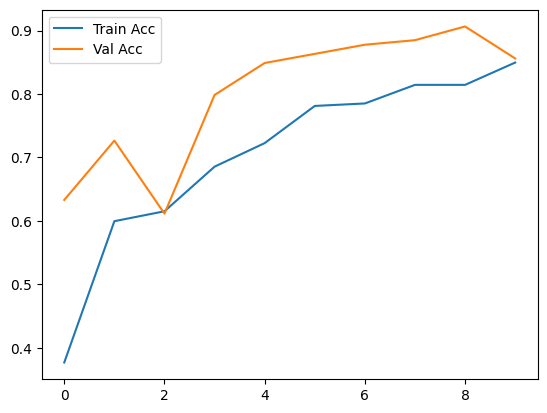

In [45]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load pre-trained VGG16 model (excluding top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(augmented_train_ds, epochs=10, validation_data=test_ds)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()